The goal of advertising campaigns is to encourage users to do shoppings on an online shop and to buy products of different brands.
After a single campaign is finished we have to deliver the following report:
  - number of clicks on advertising banners
  - number of transactions made after our banner was clicked (so called the post click model)
  - advertising campaign cost which is compound of the following:
    - 0.01 units for a single click
    - 10% out of value of each transaction
  - value of all purchased products in the post click model
  - data is aggregated monthly based on a transaction date, identifier of an advertising campaign which delivered a value, brand of a purchased product

So the final report must be compound of the following columns:
number_of_clicks, number_of_transactions, advertising_campaign_cost, value_of_products
Aggregated by: month, campaign_id, brand

Analysis steps:
1. creating a database on your computer,
2. creating tables: <br>
    -clicks<br>
    -products<br>
    -transactions<br>
    -transactions_products<br>
3. creating relationality of the database (any way)
4. creating a relational database model
5. creating a report

# Preparing the environment: creating a database and declaration; creating tables

In [26]:
import sqlite3
# space on the disk where the database will be created
path = "C:/Users/Public/dbRTB.db"

# Connect to the database or create one if it does not exist
try:
  conn = sqlite3.connect(path)
  print("Database dane.db formed.")
except:
  print("Database dane.db not formed.")

# Database operations

# create object cursor
cursor = conn.cursor()

# create tables
sql_create_clicks_table = '''
CREATE TABLE clicks (
  user_id INT,
  date DATE,
  campaign_id INT,
  product_id INT
)
'''

sql_create_products_table = '''
CREATE TABLE products (
  id INT,
  price DECIMAL(10, 2),
  name VARCHAR(100),
  brand VARCHAR(50),
  product_catalog_id INT
)
'''

sql_create_transactions_table = '''
CREATE TABLE transactions (
  transaction_id INT,
  user_id INT,
  date DATE,
  campaign_id INT,
  transaction_value DECIMAL(10, 2)
)
'''

sql_create_transactions_products_table = '''
CREATE TABLE transactions_products (
  transaction_id INT,
  product_id INT
)
'''

# exec sql codes
cursor.execute(sql_create_clicks_table)
cursor.execute(sql_create_products_table)
cursor.execute(sql_create_transactions_table)
cursor.execute(sql_create_transactions_products_table)


# commit changes
conn.commit()

Database dane.db formed.


# Zasilenie tabel danymi z plików csv

In [28]:
import csv

# Import data from a CSV file into the clicks table
with open('clicks.csv', 'r') as file:
    csv_data = csv.reader(file)
    next(csv_data)  # Skip column headings
    for row in csv_data:
        cursor.execute("INSERT INTO clicks (user_id, date, campaign_id, product_id) VALUES (?, ?, ?, ?)", row)

# Import data from a CSV file into the products table
with open('products.csv', 'r') as file:
    csv_data = csv.reader(file)
    next(csv_data)  # Skip column headings
    for row in csv_data:
        cursor.execute("INSERT INTO products (id, price, name, brand, product_catalog_id) VALUES (?, ?, ?, ?, ?)", row)

# Import data from the CSV file into the transactions table
with open('transactions.csv', 'r') as file:
    csv_data = csv.reader(file)
    next(csv_data)  # Skip column headings
    for row in csv_data:
        cursor.execute("INSERT INTO transactions (transaction_id, user_id, date, campaign_id, transaction_value) VALUES (?, ?, ?, ?, ?)", row)

# Import data from the CSV file into the transactions_products table
with open('transactions_products.csv', 'r') as file:
    csv_data = csv.reader(file)
    next(csv_data)  # Skip column headings
    for row in csv_data:
        cursor.execute("INSERT INTO transactions_products (transaction_id, product_id) VALUES (?, ?)", row)

# commit changes
conn.commit()

# Creation of a data model and data analysis
### For analysis purposes, I checked each table in the pandas module for data integrity and uniqueness. It turned out that each table does not have nulls on the ID keys, but in each table there are doubles on the ID keys, which causes many-to-many relationships, which prevents the database from being relational. I solved this as follows. I assumed that I was analyzing for 1 distinct ID(ID = 282874739153063906) from the product table. This allowed me to conduct further analysis.

## The attached image shows what the ERD diagram for the data model for the selected ID looks like

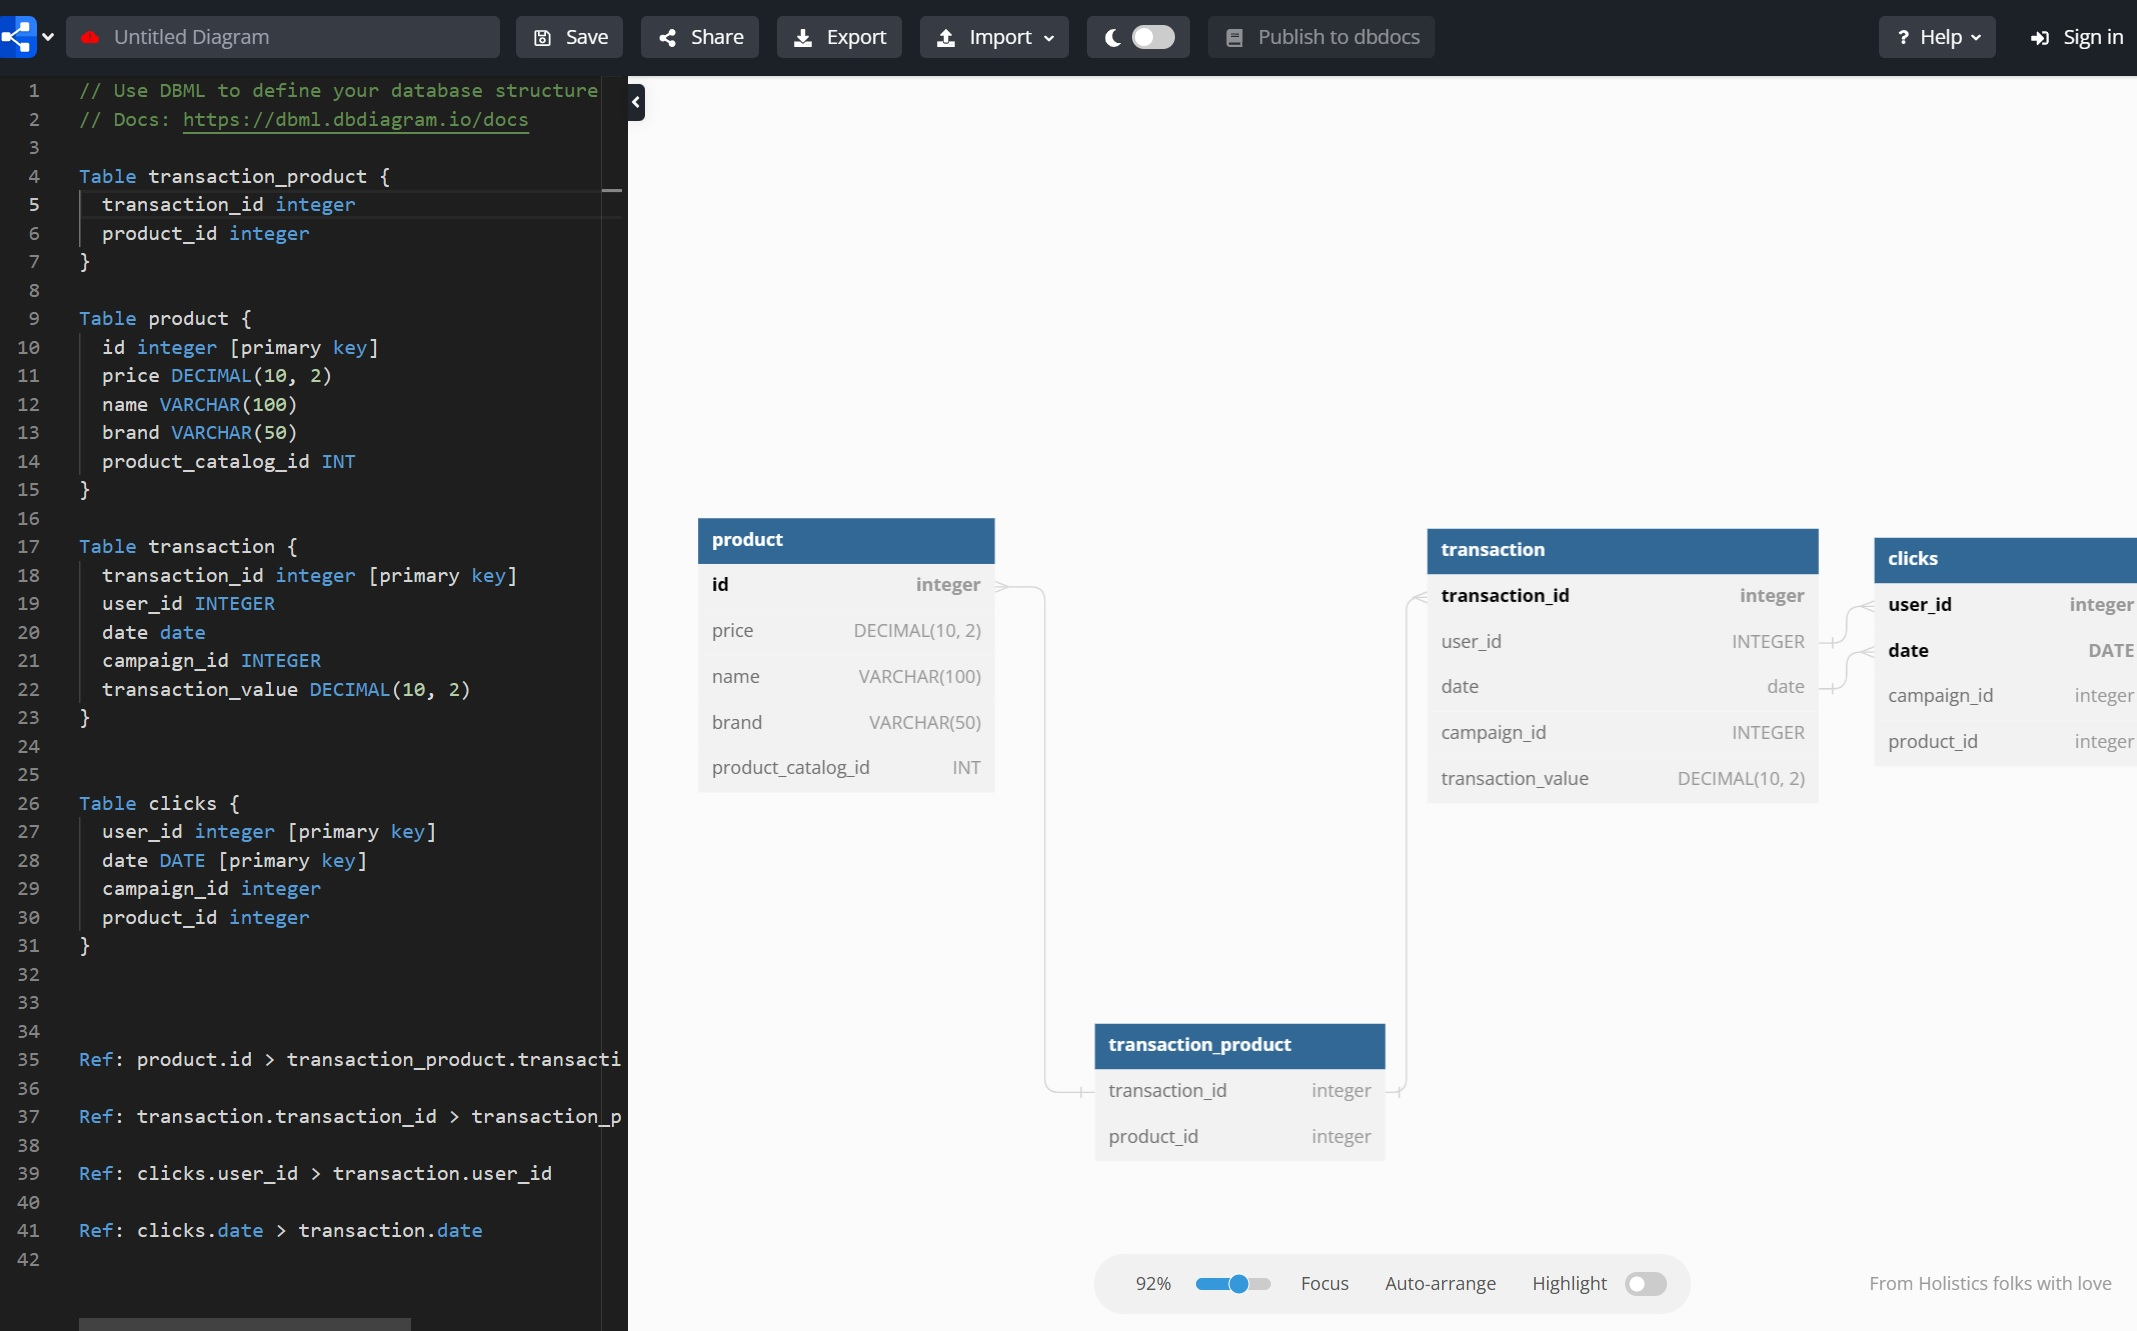

In [16]:
from IPython.display import Image
Image("Diagram ERD.jpg")

# Checking data for a given ID on individual tables (does it make logical sense)

### There is one ID in the products table thanks to distinct

In [29]:
import pandas as pd

query = '''
SELECT DISTINCT 
    id, 
    brand
FROM products
WHERE id = 282874739153063906;
'''
df = pd.read_sql_query(query, conn)

# Display the result as a DataFrame
print(df)

                   id brand
0  282874739153063906     M


### On the transactions_products table with the selected ID we have 1 product_id and many transaction_IDs. We have achieved what we wanted, we can make a connection between tables in a many-to-many relationship with a join table

In [30]:
query = '''
SELECT * 
FROM transactions_products
WHERE product_id = 282874739153063906;
'''
df = pd.read_sql_query(query, conn)

# Display the result as a DataFrame
print(df)

        transaction_id          product_id
0   188142577268151597  282874739153063906
1 -1191850485846685474  282874739153063906
2  8192167647413201033  282874739153063906
3 -1539754714053407754  282874739153063906
4 -6447579458631946065  282874739153063906
5  2479590044707331820  282874739153063906
6 -6760358067308953928  282874739153063906
7  7975196653609340163  282874739153063906
8  7061710405545185669  282874739153063906
9  5813933668814000465  282874739153063906


### Thanks to this, for each transaction id we have information from the transaction table, and from the transaction table we can extract information from the clicks table after user_id. Example below.

In [31]:
query = '''
SELECT * 
FROM transactions
WHERE transaction_id = 188142577268151597;
'''
df = pd.read_sql_query(query, conn)

# Display the result as a DataFrame
print(df)

       transaction_id              user_id        date          campaign_id  \
0  188142577268151597 -7918238331087704952  2022-03-10 -2276661325946873216   

   transaction_value  
0            1852.79  


In [32]:
query = '''
SELECT * 
FROM clicks
WHERE user_id = -7918238331087704952;
'''
df = pd.read_sql_query(query, conn)

# Display the result as a DataFrame
print(df)

               user_id        date          campaign_id           product_id
0 -7918238331087704952  2022-02-13 -2276661325946873216  4997676985057583318
1 -7918238331087704952  2022-02-15 -2276661325946873216  1146180687291559213
2 -7918238331087704952  2022-02-16 -2276661325946873216  1146180687291559213
3 -7918238331087704952  2022-03-02 -2276661325946873216  9076847964220566218
4 -7918238331087704952  2022-03-12 -2276661325946873216  -346621972384427475
5 -7918238331087704952  2022-03-27 -2276661325946873216  4997676985057583318


# Final query data analysis
### In this query, I assumed when joining the clicks table that the click date cannot be greater than the transaction date because if the click in the product and user area took place after the transaction, it no longer applies to this transaction

In [33]:
query = '''
SELECT  
    main.brand, 
    main.month, 
    main.campaign_id, 
    main.number_of_clics, 
    main.number_of_transactions, 
    (0.01*main.number_of_clics * 0.1*main.transaction_value) AS advertising_capmaign_cost, 
    SUM(main.transaction_value) AS value_of_al_purchased_prod 
FROM
(

    SELECT 
        prod.brand, 
        STRFTIME('%m', tran.date) AS month, 
        tran.campaign_id, 
        tran.transaction_value, 
        COUNT(clic.user_id) AS number_of_clics, 
        COUNT(distinct tran.transaction_id) AS number_of_transactions
    FROM 
        (
            SELECT DISTINCT 
                            id, 
                            brand 
            FROM products 
            WHERE id = 282874739153063906
        ) prod
    LEFT JOIN transactions_products tran_prod ON prod.id=tran_prod.product_id
    LEFT JOIN transactions tran ON tran_prod.transaction_id = tran.transaction_id
    INNER JOIN clicks clic ON tran.user_id = clic.user_id AND clic.date <= tran.date
    GROUP BY 
    prod.id, 
    prod.brand, 
    STRFTIME('%m', tran.date), 
    tran.campaign_id, 
    tran.transaction_value
)main
GROUP BY 
main.brand, 
main.month, 
main.campaign_id, 
main.number_of_clics, 
main.number_of_transactions, 
(0.01*main.number_of_clics * 0.1*main.transaction_value);
'''
df1 = pd.read_sql_query(query, conn)

# Show the result as a DataFrame
df1.head()

,brand,month,campaign_id,number_of_clics,number_of_transactions,advertising_capmaign_cost,value_of_al_purchased_prod
0,M,03,-2276661325946873216,4,1,7.41116,1852.79


# Save to csv

In [34]:
df1.to_csv('C:/Users/Public/analiza.csv')